In [96]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from codes.data_loader import *
from codes.model_utils import *
from codes.evaluations.eval_utils import *


# Create Directory and Add Science Styles
plt.style.use(['science', 'ieee'])
plt.rcParams["text.usetex"] = False
plt.rcParams['figure.figsize'] = 6, 2
os.makedirs('plots', exist_ok=True)

In [97]:
best_configs = {}

def get_best_config(algo_name):
    best_configs["USAD"] = {
        "num_epochs": 15,
        "num_hidden": 16,
        "latent": 5,
        "learning_rate": 0.0001,
        "weight_decay": 1e-5,
        "num_window": 10,
    }
    
    best_configs["AE"] = {
        "num_epochs": 15,
        "learning_rate": 0.0001,
        "weight_decay": 1e-5,
        "num_window": 15,
    }

    best_configs["DAGMM"] = {
        "beta": 0.01,
        "embedding_dim": 16,
        "num_epochs": 15,
        "num_hidden": 16,
        "latent": 8,
        "learning_rate": 0.0001,
        "weight_decay": 1e-5,
        "num_window": 5,
    }

    best_configs["MAD_GAN"] = {
        "num_epochs": 15,
        "num_hidden": 16,
        "learning_rate": 0.0001,
        "weight_decay": 1e-5,
        "num_window": 5,
    }

    best_configs["OmniAnomaly"] = {
        "beta": 0.01,
        "num_epochs": 15,
        "num_hidden": 32,
        "latent": 8,
        "learning_rate": 0.002,
        "weight_decay": 1e-5,
    }

    best_configs["MSCRED"] = {
        "num_epochs": 15,
        "learning_rate": 0.0001,
        "weight_decay": 1e-5,
    }
    
    best_configs["LSTM_AD"] = {
        "num_epochs": 15,
        "num_hidden": 64,
        "learning_rate": 0.0001,
        "weight_decay": 1e-5,
    }
    
    best_configs["LSTM_Univariate"] = {
        "num_epochs": 15,
        "num_hidden": 1,
        "learning_rate": 0.0001,
        "weight_decay": 1e-5,
    }

    return best_configs[algo_name]

In [98]:
device = 'dev5'
dataset = 'ENERGY'
modelname = 'OmniAnomaly'
config = get_best_config(modelname)
args = {
    "model": modelname,
    "dataset": dataset,
}

In [99]:
def load_my_model(modelname, dims, config):
    try:
        import codes.models
        model_class = getattr(codes.models, modelname)
        model = model_class(dims, config).double()
        optimizer = torch.optim.AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, 0.9)
        fname = f'checkpoints/{modelname}_{dataset}/model.ckpt'
        # fname = ''
        if os.path.exists(fname):
            print(f"Loading pre-trained model: {model.name}")
            checkpoint = torch.load(fname)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            epoch = checkpoint['epoch']
            accuracy_list = checkpoint['accuracy_list']
        else:
            print(f"Creating new model: {model.name}")
            epoch = -1
            accuracy_list = []
        return model, optimizer, scheduler, epoch, accuracy_list
    except:
        epoch = -1
        accuracy_list = []
        return model, optimizer, scheduler, epoch, accuracy_list

In [100]:
train_loader, test_loader, labels = client_load_dataset(dataset, device)
model, optimizer, scheduler, epoch, accuracy_list = load_my_model(modelname, labels.shape[1], config)

Loading pre-trained model: OmniAnomaly


In [101]:
trainD, testD = next(iter(train_loader)), next(iter(test_loader))
trainO, testO = trainD, testD
if model.name in ['USAD', 'AE', 'DAGMM', 'MAD_GAN', 'MSCRED']:
    trainD, testD = convert_to_windows(trainD, model), convert_to_windows(testD, model)
model.eval()
with torch.no_grad():
    loss, mae, y_pred = backprop(0, model, testD, testO, optimizer, scheduler, training=False)
    ### Scores
    lossT, _, _ = backprop(0, model, trainD, trainO, optimizer, scheduler, training=False)
    for i in range(loss.shape[1]):
        lt, l, ls = lossT[:, i], loss[:, i], labels[:, i]
        result, _ = pot_eval(lt, l, ls)
        
    lossTfinal, lossFinal = np.mean(lossT, axis=1), np.mean(loss, axis=1)
    labelsFinal = (np.sum(labels, axis=1) >= 1) + 0
    
    result, _ = pot_eval(lossTfinal, lossFinal, labelsFinal)
    print("F1", result['f1'])
    print("ROC/AUC", result['ROC/AUC'])

F1 0.41183102560644574
ROC/AUC 0.6296827919522308


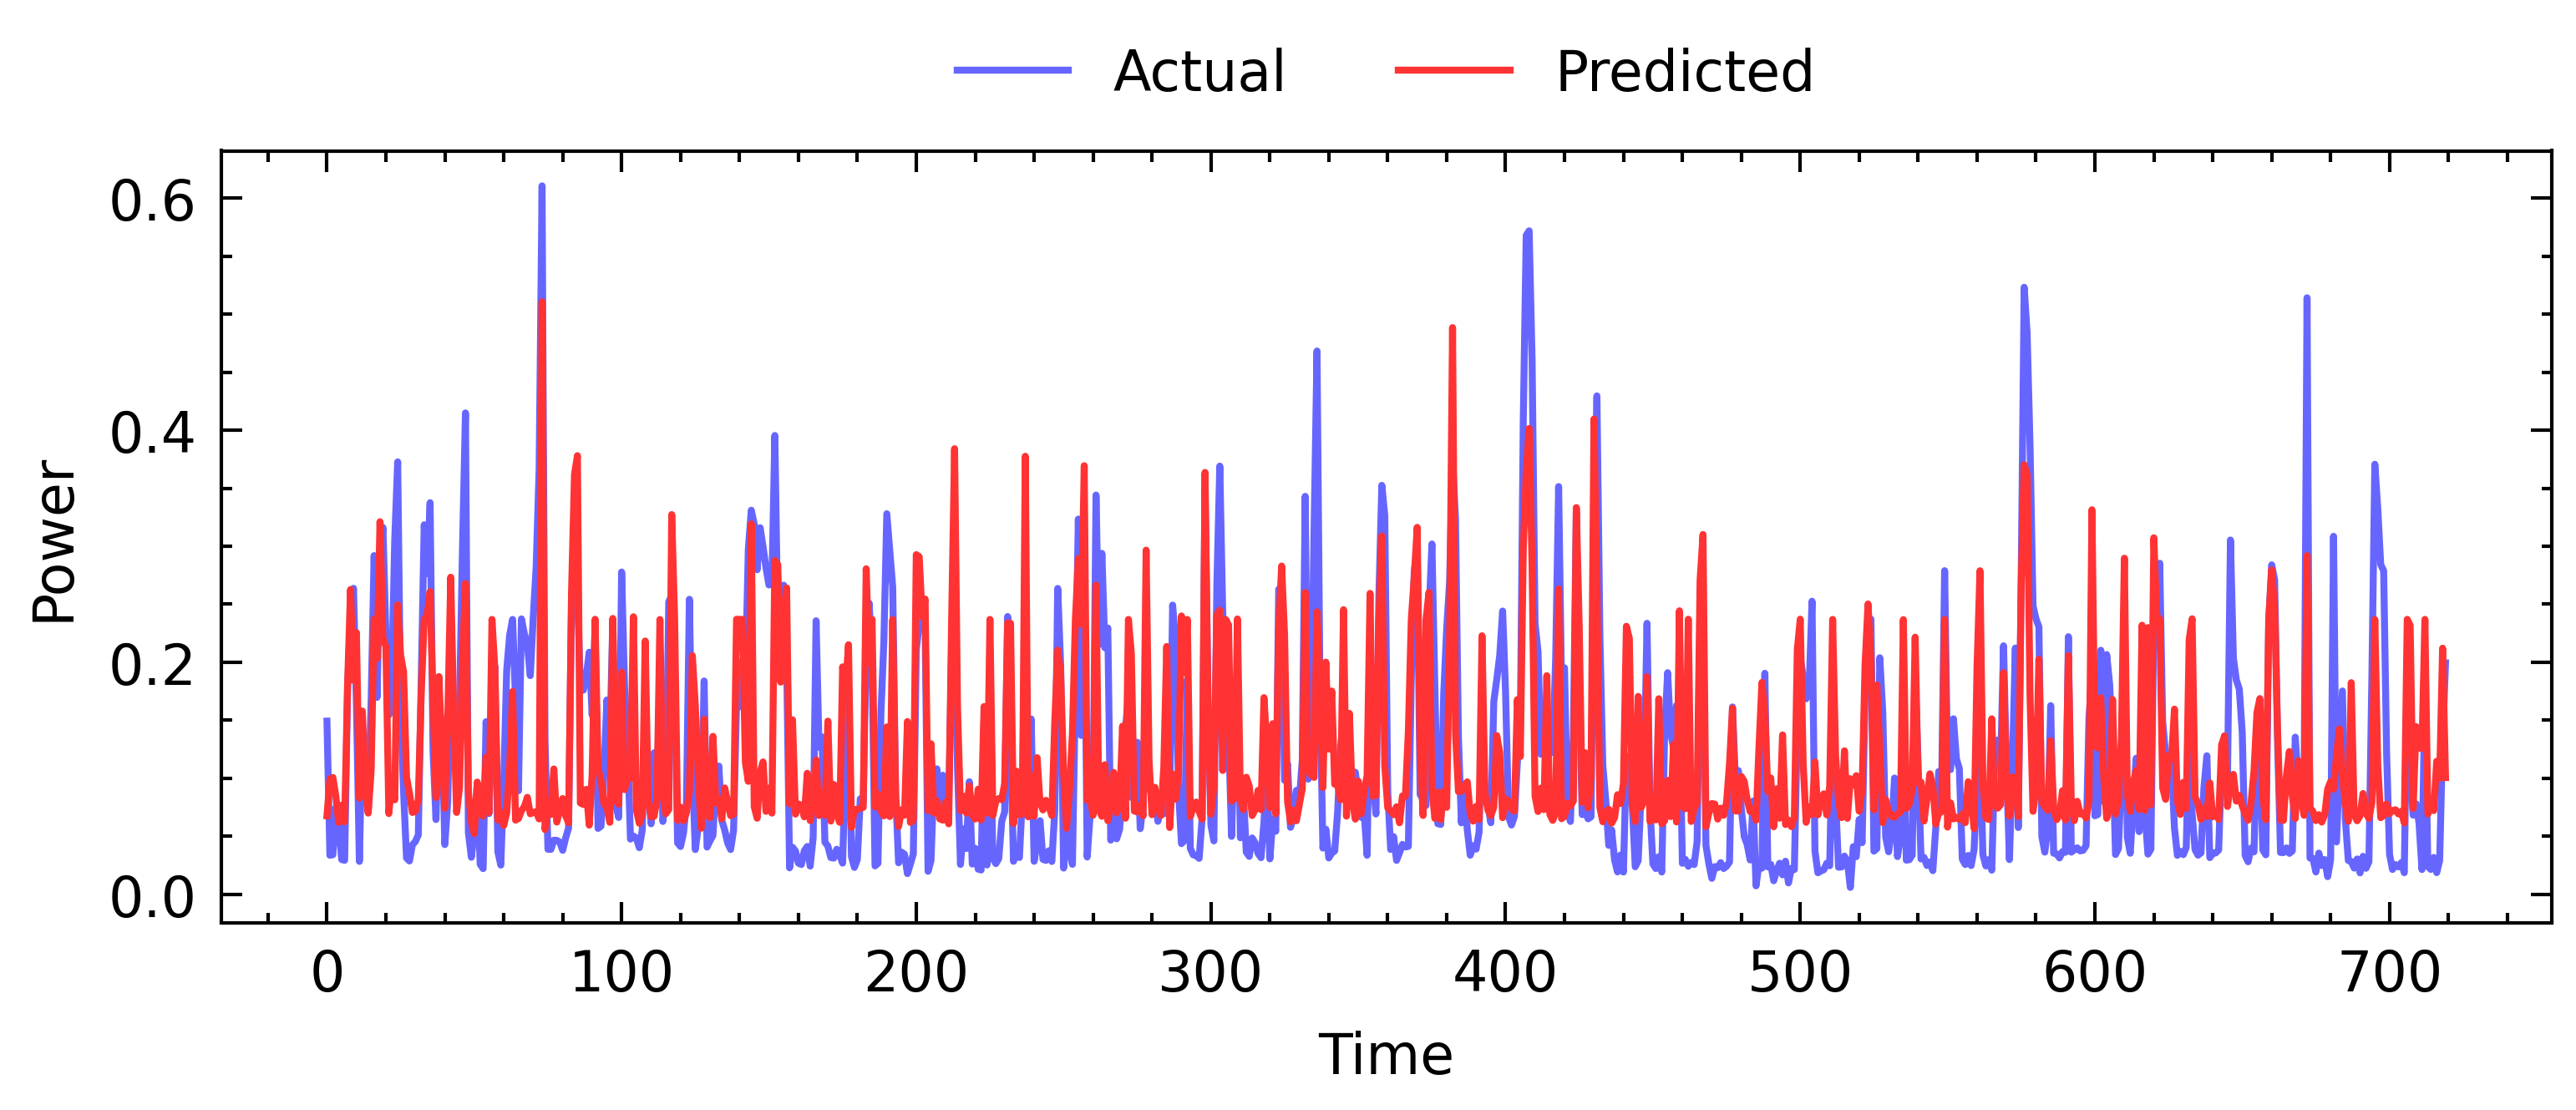

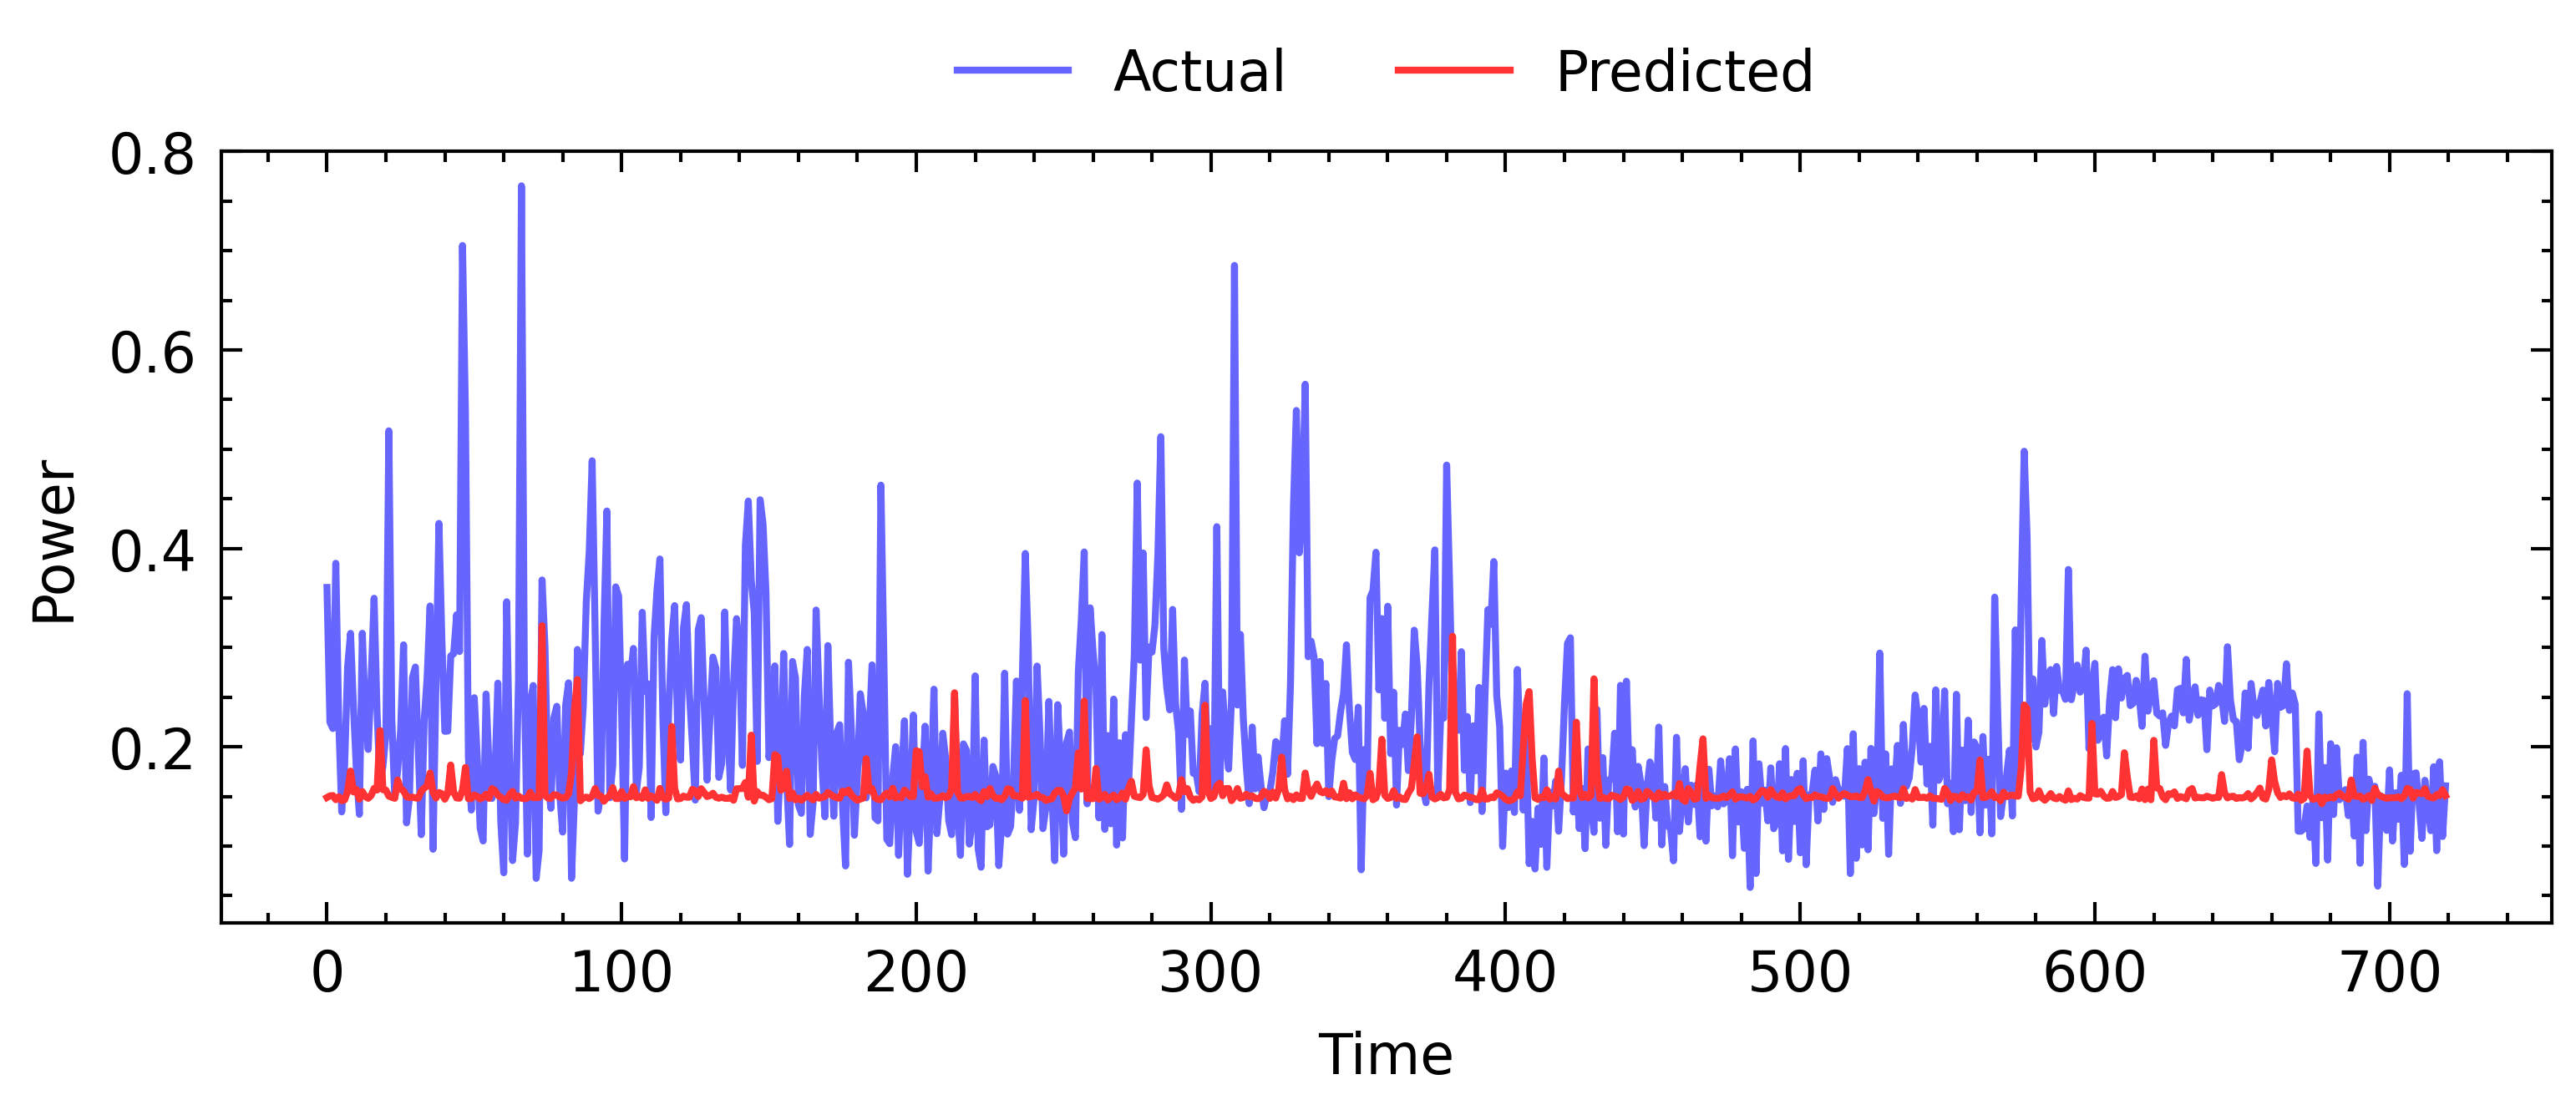

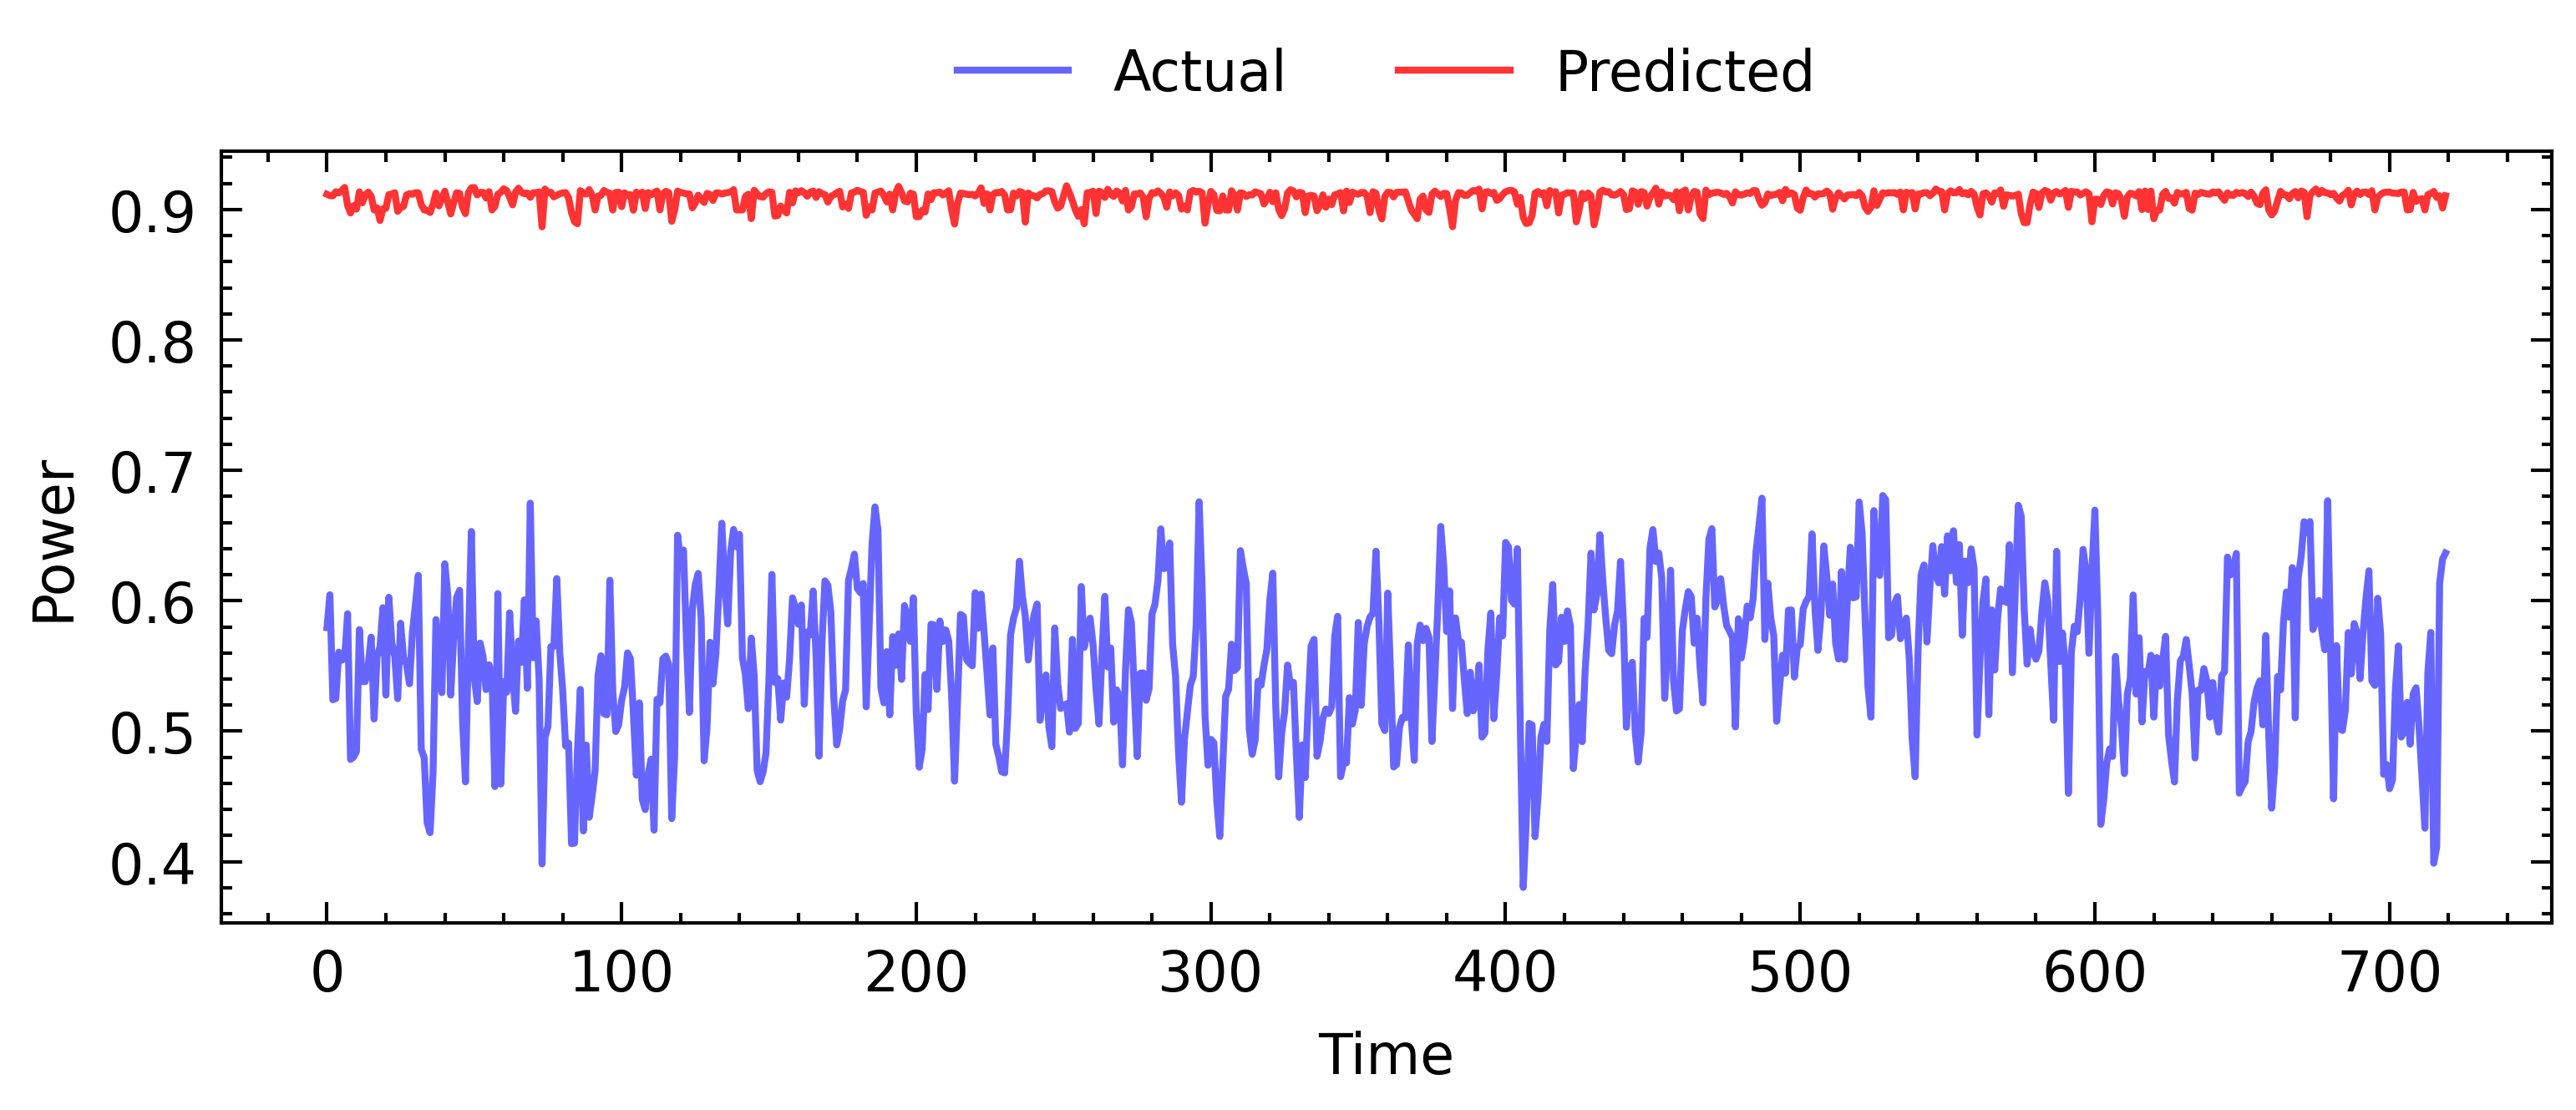

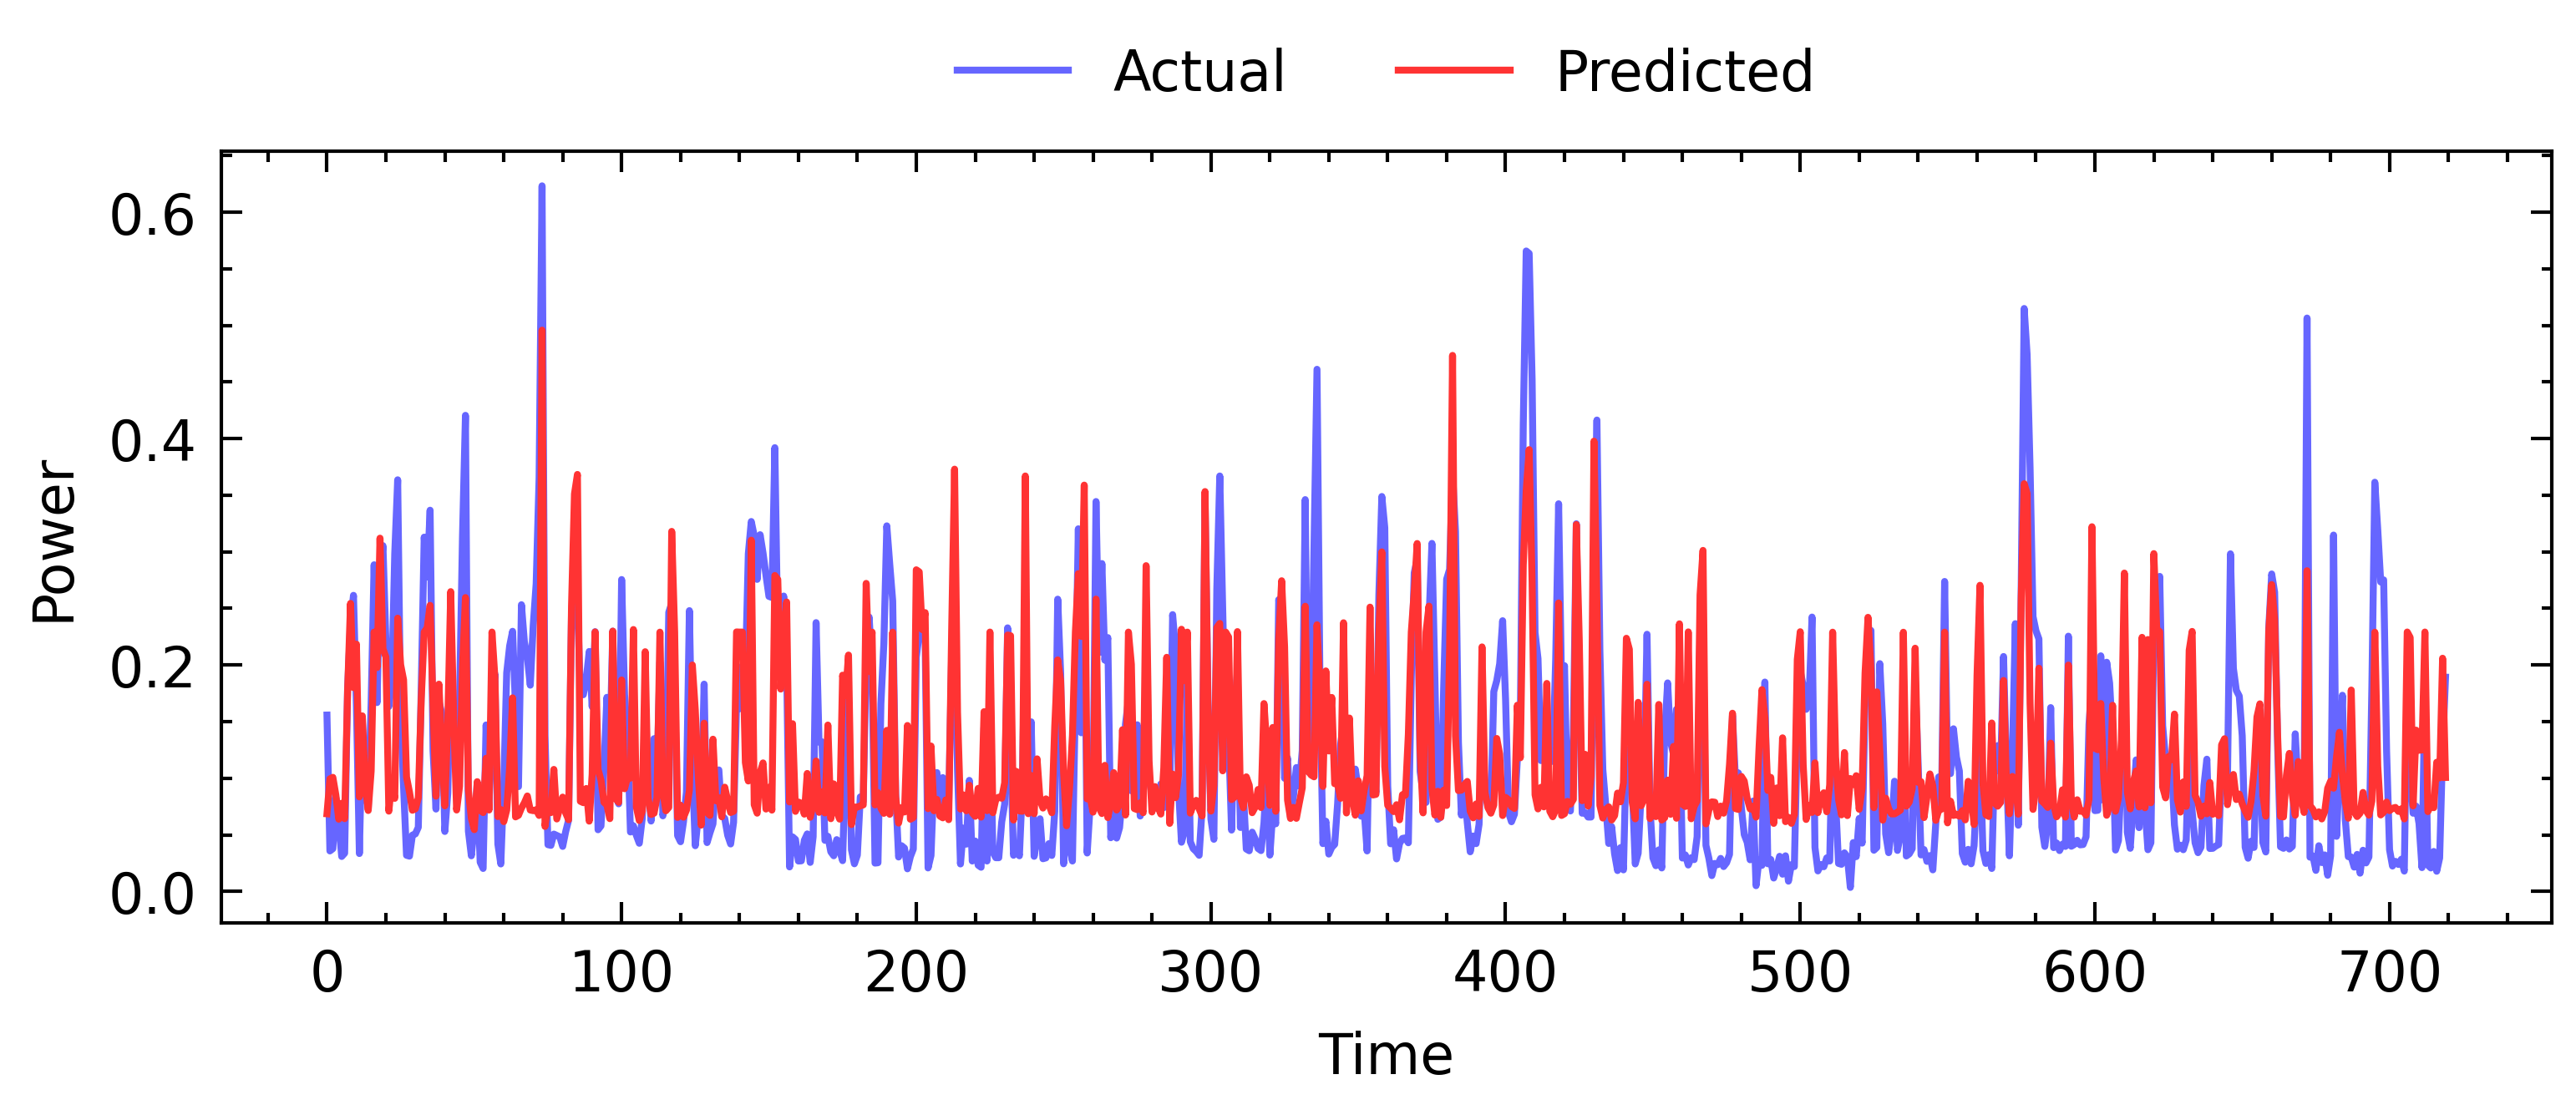

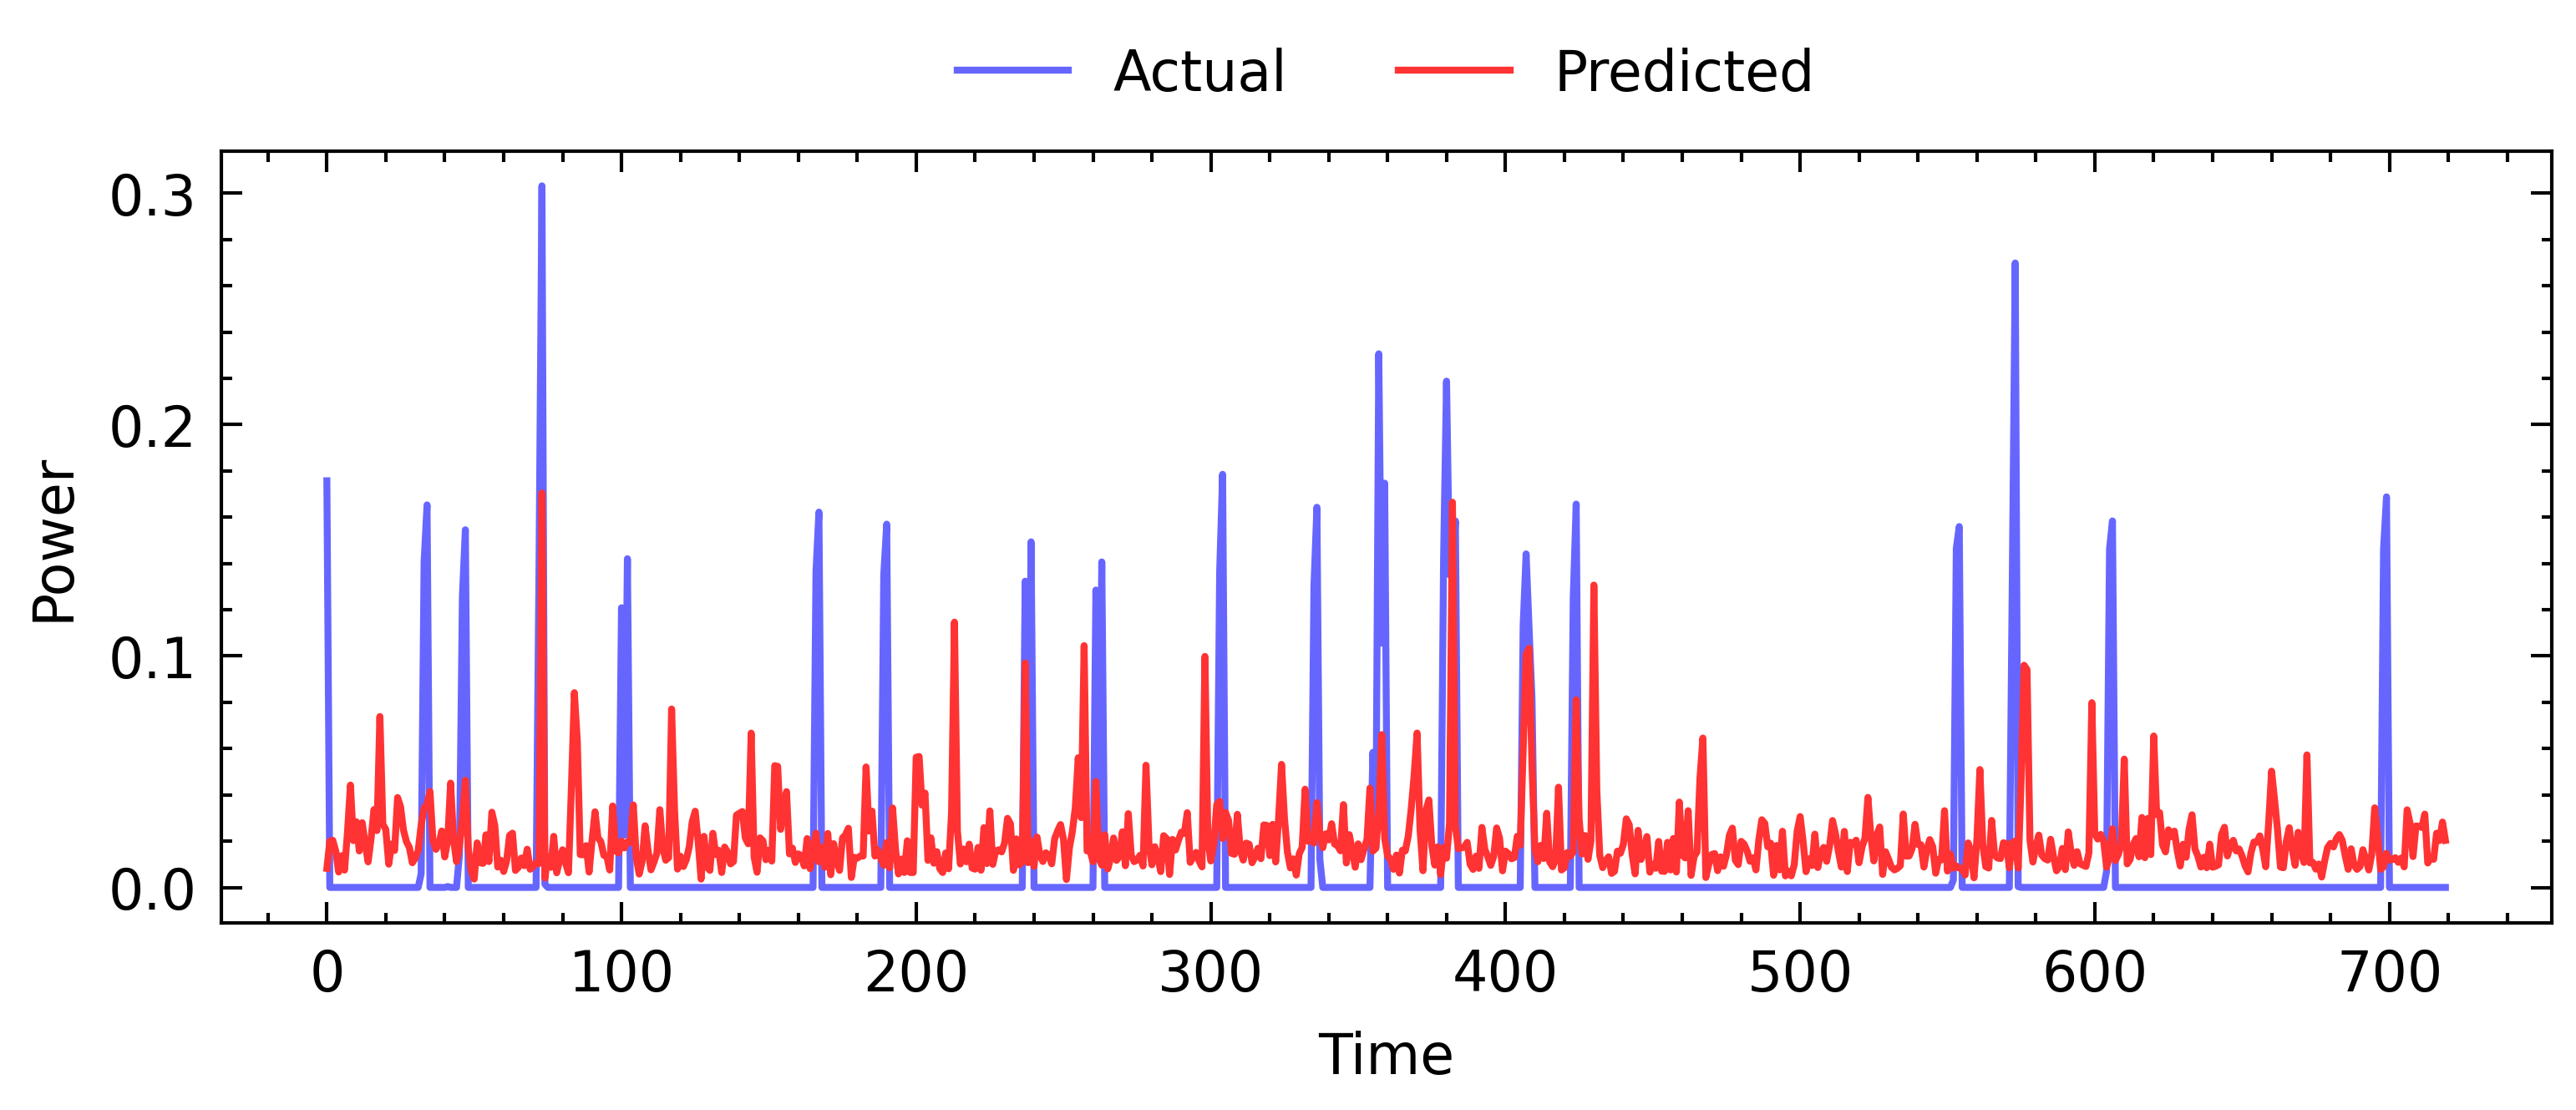

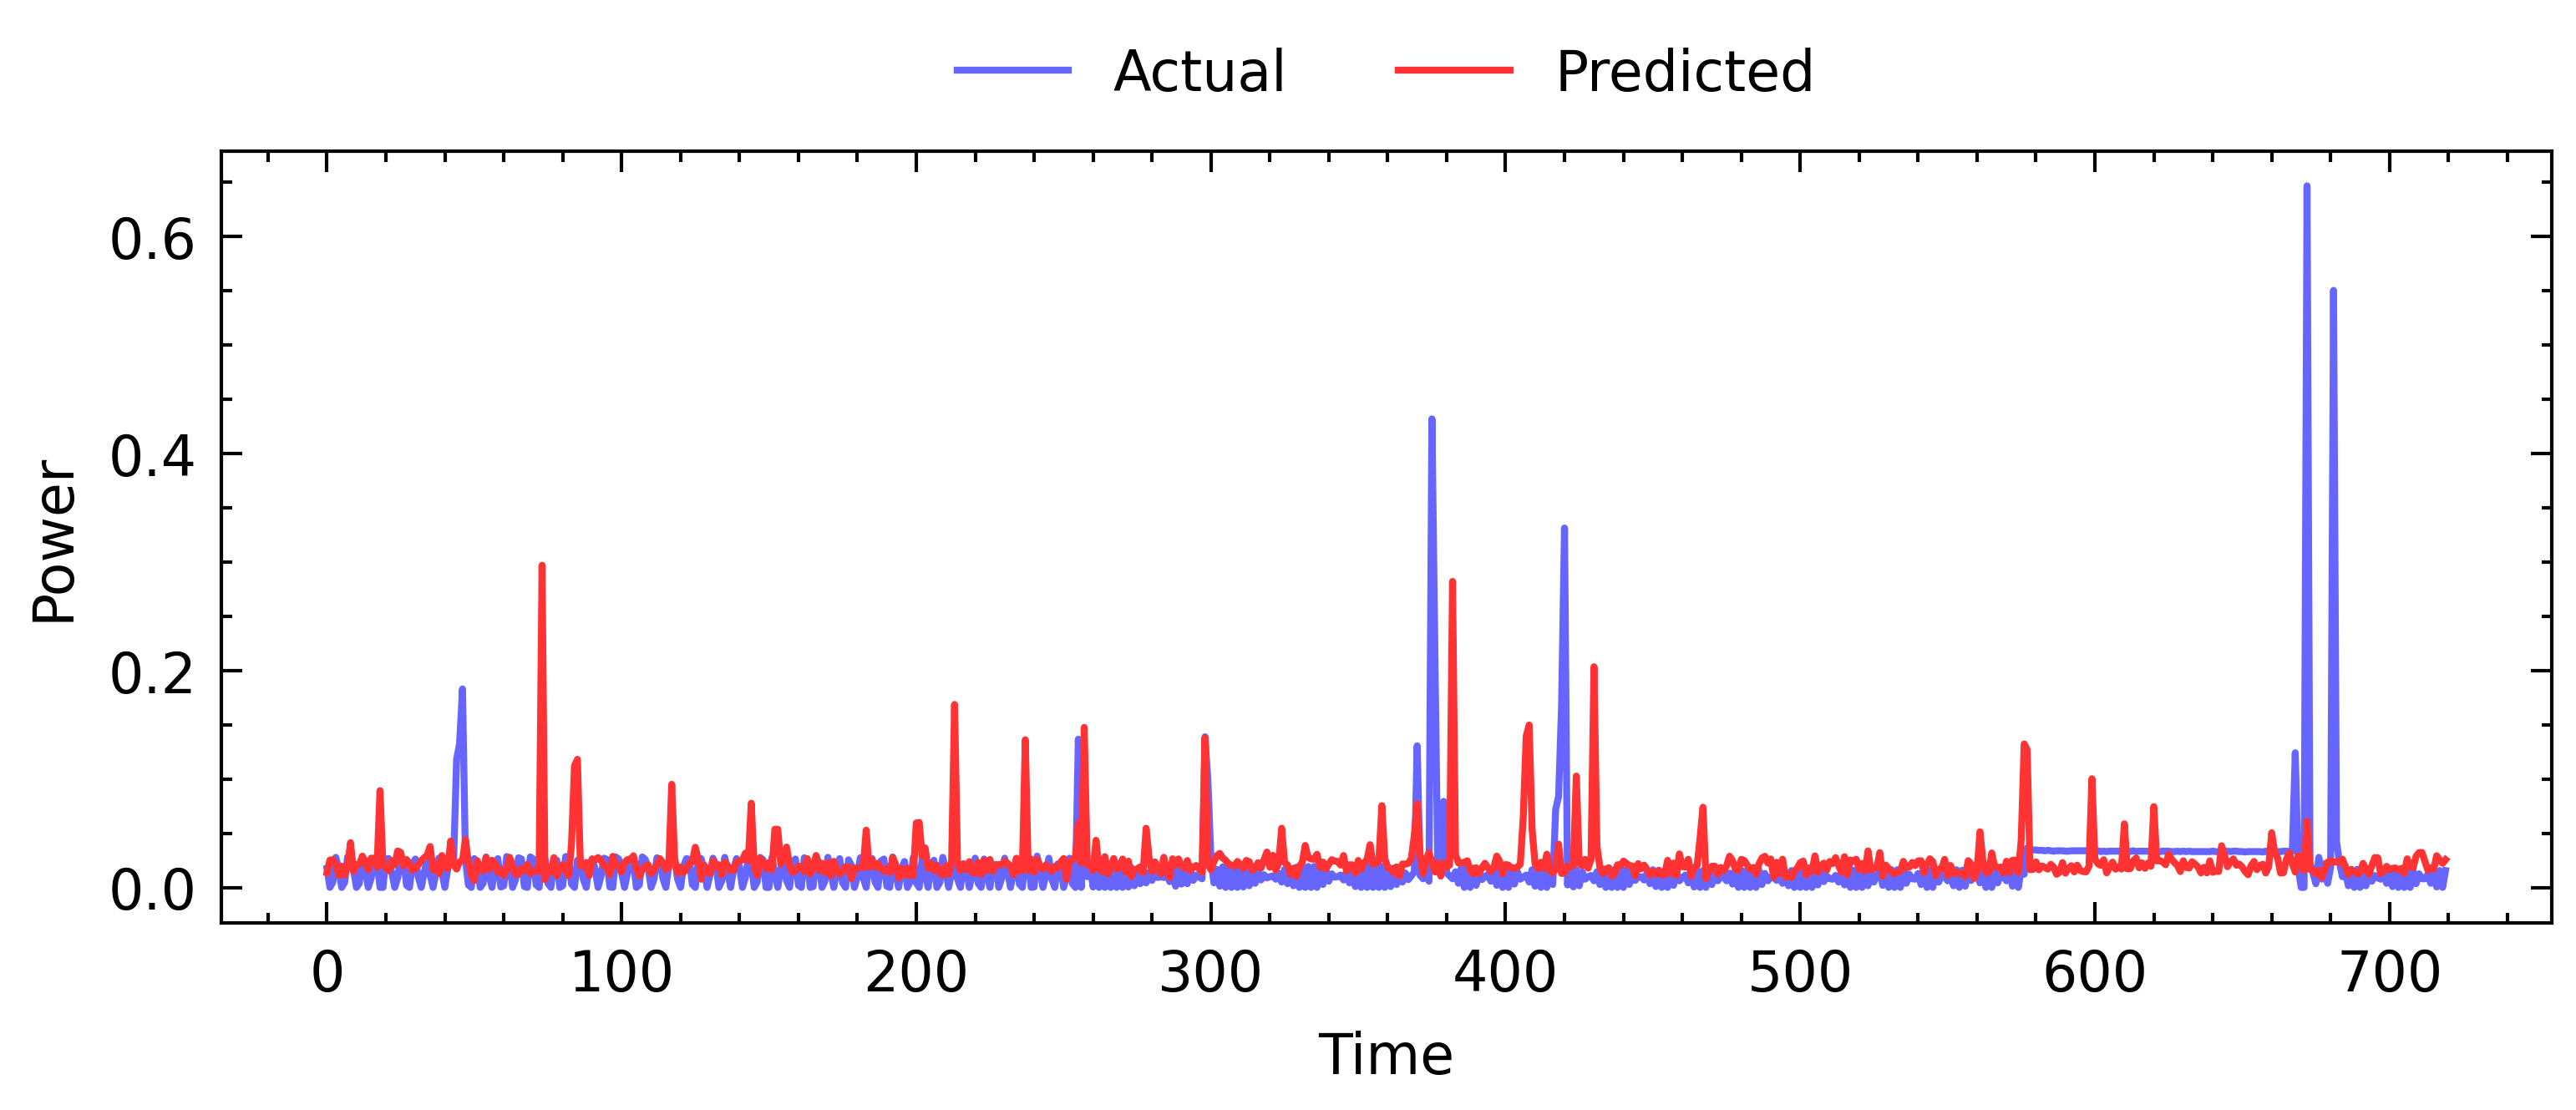

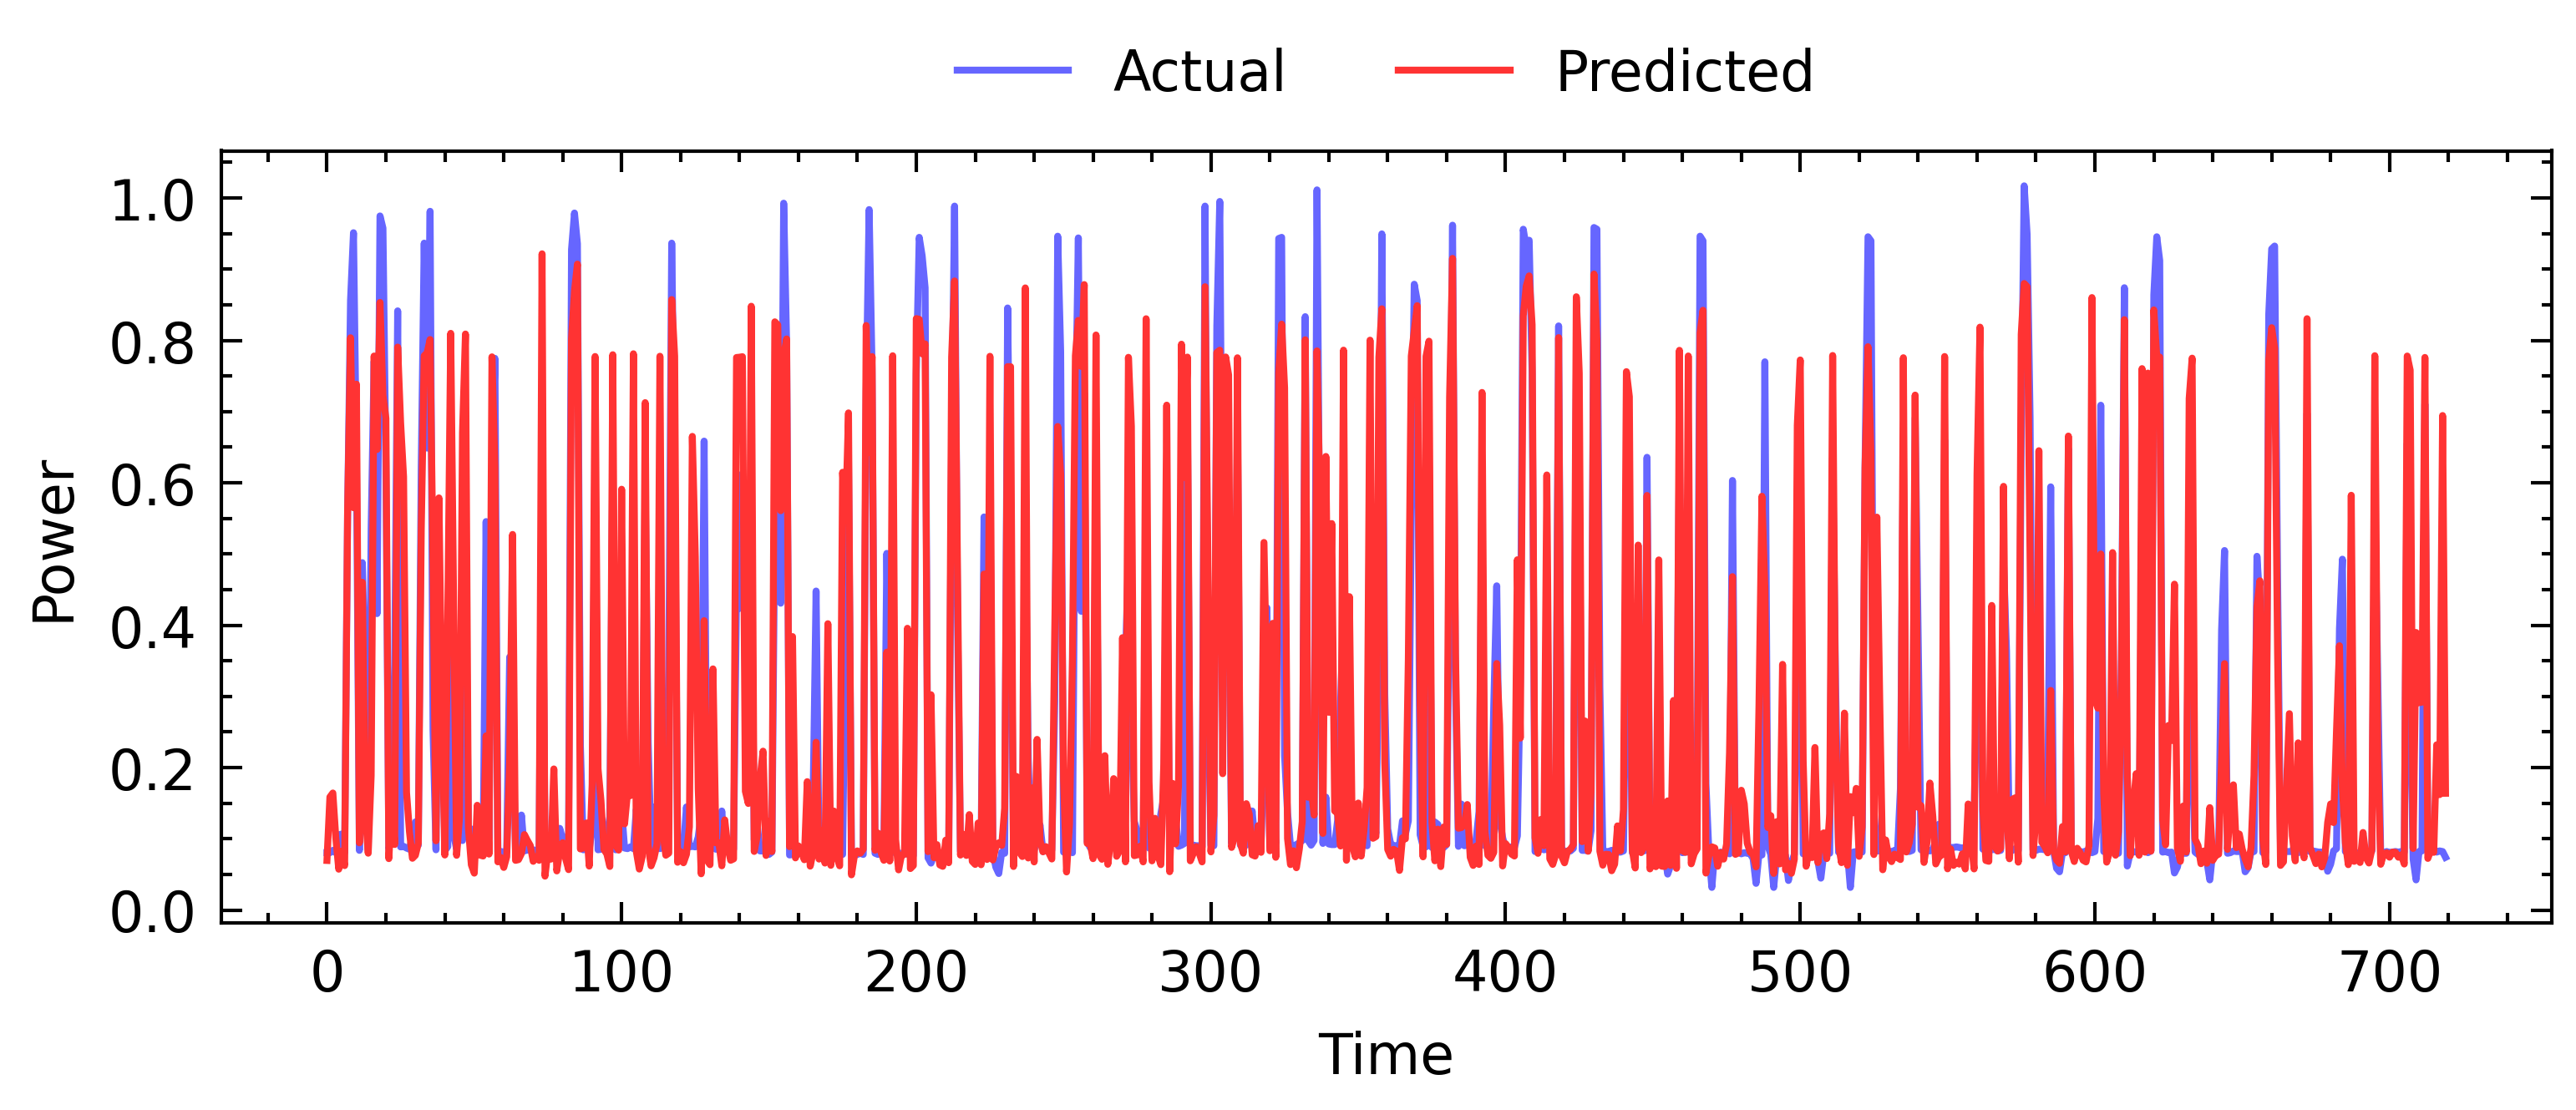

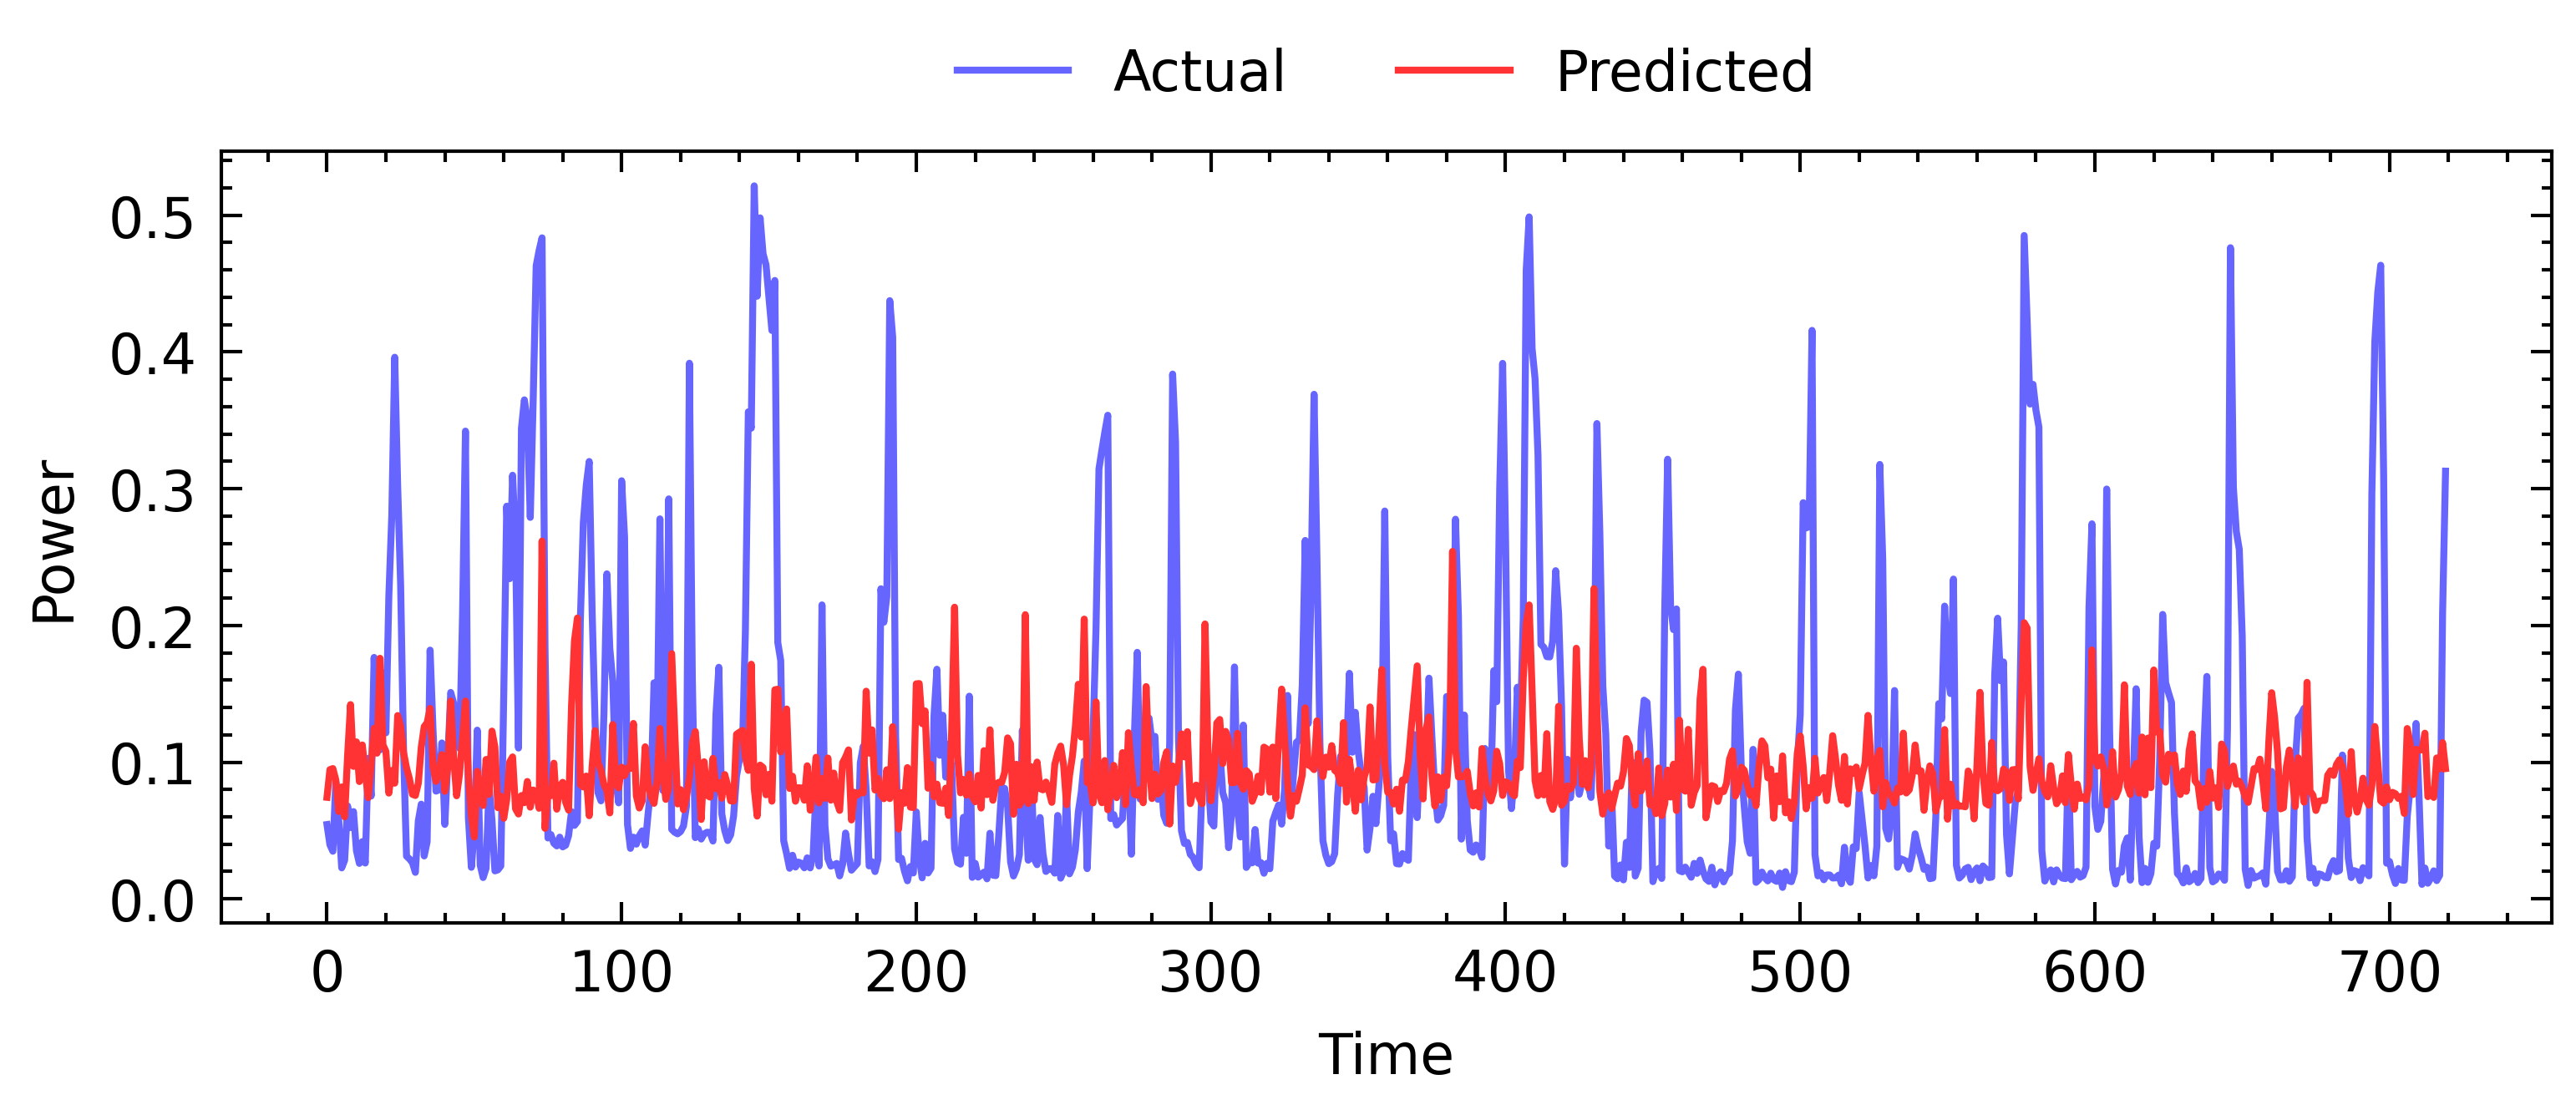

In [102]:
for dim in range(testO.shape[1]):
    fig, ax = plt.subplots()
    y_t, y_p = testO[0:720, dim], y_pred[0:720, dim]
    ax.set_ylabel('Power')
    ax.set_xlabel('Time')
    ax.plot(y_t, label='Actual', linewidth=1, color='#6666FF')
    ax.plot(y_p, label='Predicted', linewidth=1, color='#FF3333', linestyle='-')
    ax.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, 1.2),
        ncol=2,
    )

# F1 of all models

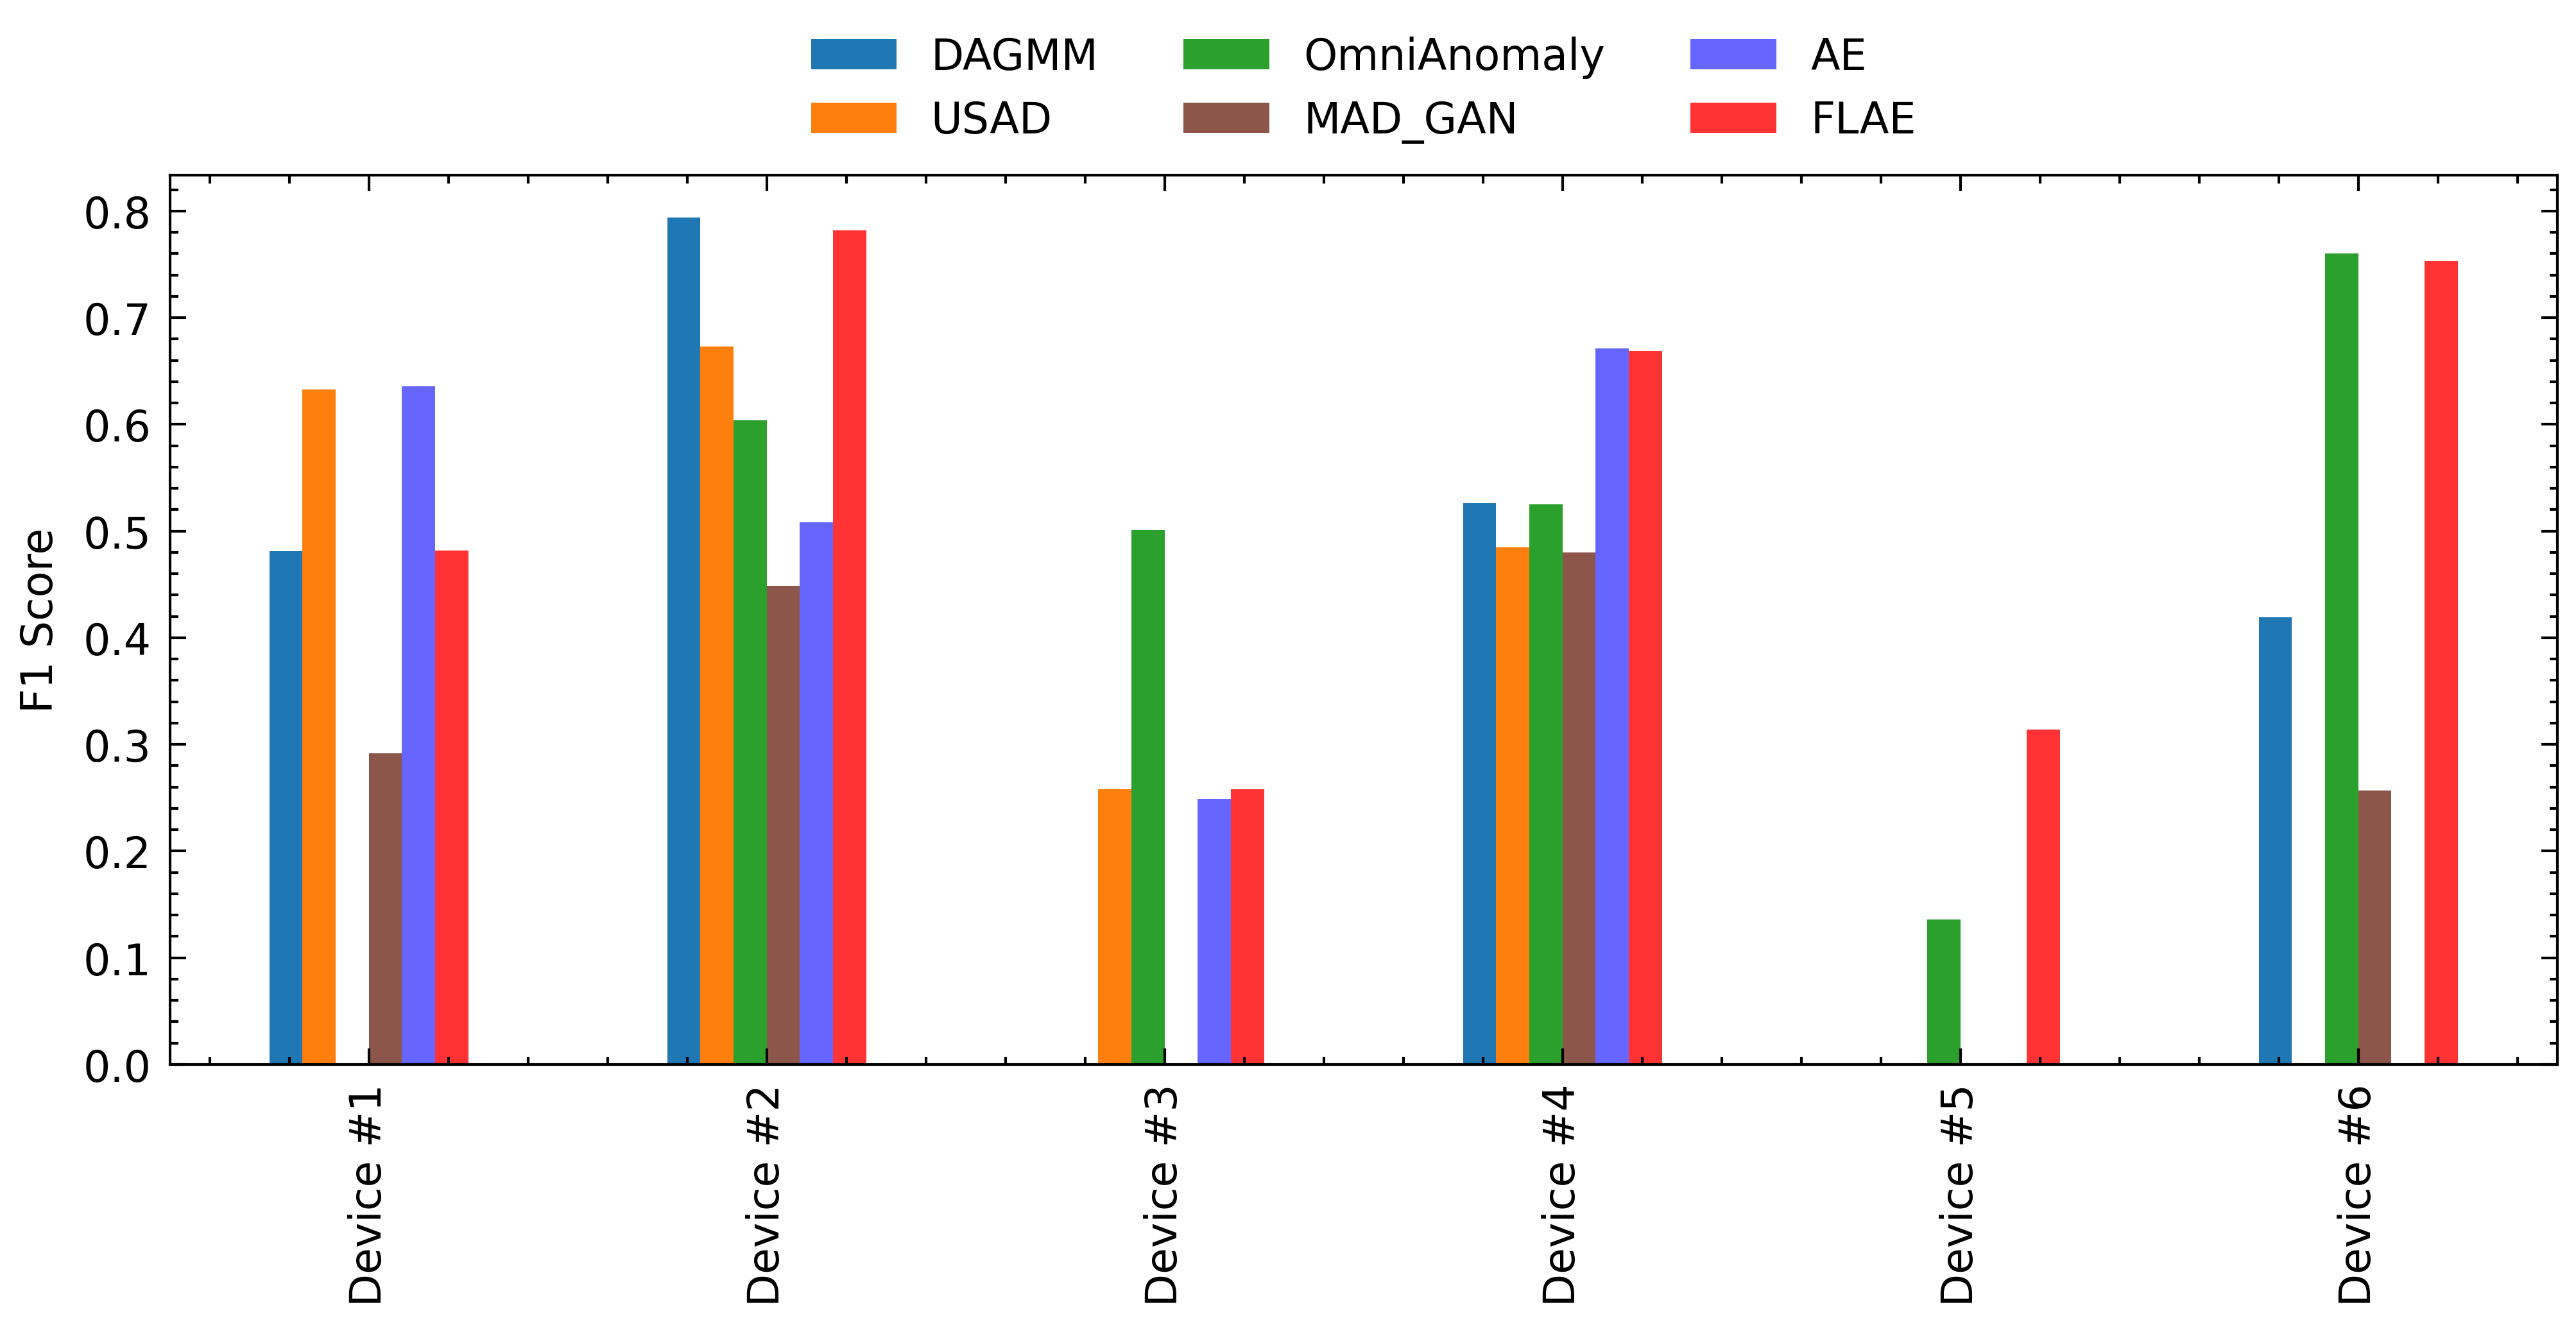

In [103]:
devices = ['Device #1', 'Device #2', 'Device #3', 'Device #4', 'Device #5', 'Device #6']

plotdata = pd.DataFrame({
    "DAGMM": [0.481, 0.794, 0.0, 0.526, 0.0, 0.419],
    "USAD": [0.633, 0.673, 0.258, 0.485, 0.000, 0.000],
    "OmniAnomaly": [0.0, 0.604, 0.501, 0.525, 0.136, 0.76],
    "MAD_GAN": [0.292, 0.449, 0.0, 0.48, 0.0, 0.257],
    "AE": [0.636, 0.508, 0.249, 0.671, 0.0, 0.0],
    "FLAE": [0.482, 0.782, 0.258, 0.669, 0.314, 0.753],
}, index=devices)

plotdata.plot(kind='bar', figsize=(8, 3), color=['#1f77b4', '#ff7f0e', '#2ca02c', '#8c564b', '#6666ff', '#ff3333']) 
  
plt.ylabel("F1 Score")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
plt.show()

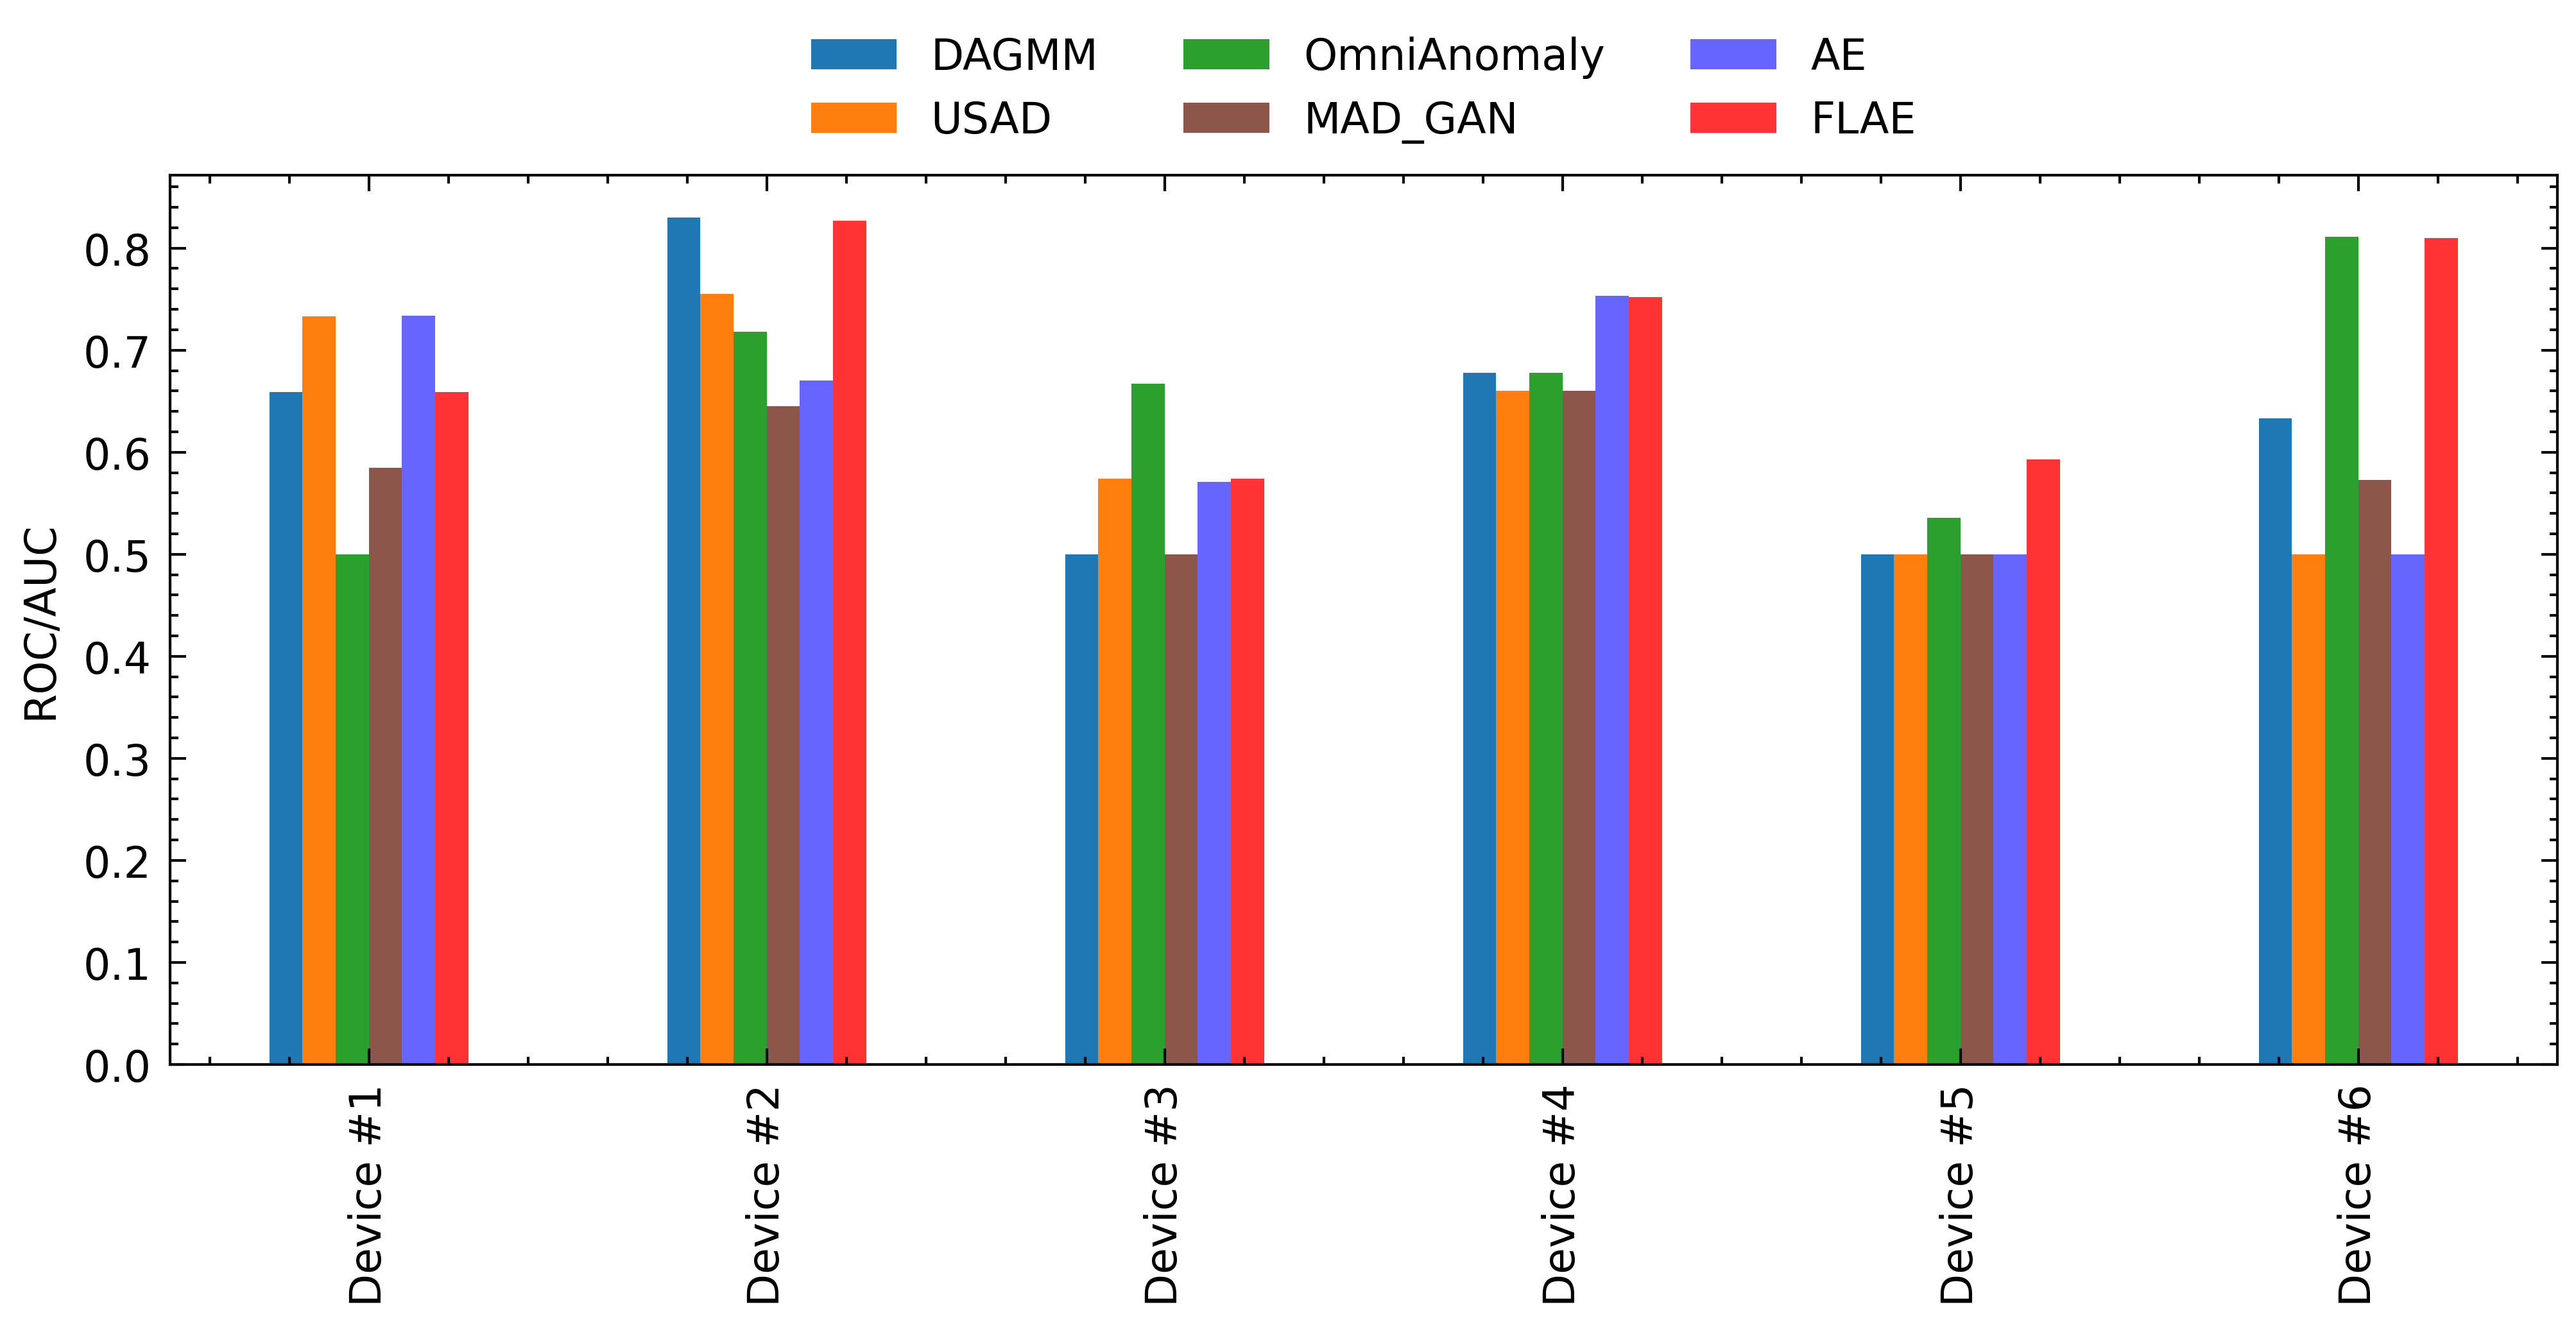

In [104]:
devices = ['Device #1', 'Device #2', 'Device #3', 'Device #4', 'Device #5', 'Device #6']

plotdata = pd.DataFrame({
    "DAGMM": [0.659, 0.830, 0.5, 0.678, 0.5, 0.633],
    "USAD": [0.733, 0.755, 0.574, 0.660, 0.5, 0.5],
    "OmniAnomaly": [0.5, 0.718, 0.667, 0.678, 0.536, 0.811],
    "MAD_GAN": [0.585, 0.645, 0.5, 0.66, 0.5, 0.573],
    "AE": [0.734, 0.67, 0.571, 0.753, 0.5, 0.5],
    "FLAE": [0.659, 0.827, 0.574, 0.752, 0.593, 0.81],
}, index=devices)

plotdata.plot(kind='bar', figsize=(8, 3), color=['#1f77b4', '#ff7f0e', '#2ca02c', '#8c564b', '#6666ff', '#ff3333']) 
  
plt.ylabel("ROC/AUC")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
plt.show()